In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from planar_code import PlanarLattice
from graph_operations import min_weight_syndrome_matching
from visualization import plot_matchings


BOUNDARIES = np.array((1,0), dtype=int)


def single_shot_correction(lattice):
    lattice.reset()
    lattice.apply_errors()
    syndrome = lattice.measure_syndrome()
    matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding='manhattan')
    for path in paths:
        lattice.apply_edge_operators(path)
    try:
        return lattice.detect_logical_errors()
    except Exception as e:
        plot_matchings(lattice, syndrome, pathfinding='manhattan')
        raise e


def logical_error_rate(p, L, samples=int(1e3), verbose=True):
    lattice = PlanarLattice(L, L, BOUNDARIES, p)
    logical_errors = []
    sample_range = tqdm(
        range(samples),
        desc=f'Calculating logical errors for p={round(p,3)} on length {L} square lattice'
    ) if verbose else range(samples)
    for _ in sample_range:
        logical_errors.append(single_shot_correction(lattice))
    return np.array(logical_errors)


def linear_sweep(L, domain=(0,1), points=100, samples_per_point=int(1e4)):
    p_array = np.linspace(*domain, points+2)
    logical_errors = []
    for p in tqdm(
        p_array,
        desc=f'L={L}: Sweeping {points} values over domain {[round(d, 3) for d in domain]}'
    ):
        logical_errors.append(logical_error_rate(p, L, samples=samples_per_point, verbose=False))
    return p_array, np.stack(logical_errors, axis=0)

In [2]:
SAVE_DIR = 'temp'
SAVED_FILES = []

In [4]:
for L in [12, 14]:
    fname = os.path.join(SAVE_DIR, f'{L}.csv')
    ps, a = linear_sweep(L, domain=(0,0.3), points=100, samples_per_point=1000)
    np.savetxt(fname, a)

L=10: Sweeping 100 values over domain [0, 0.3]:   0%|          | 0/102 [00:00<?, ?it/s]

L=12: Sweeping 100 values over domain [0, 0.3]:   0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

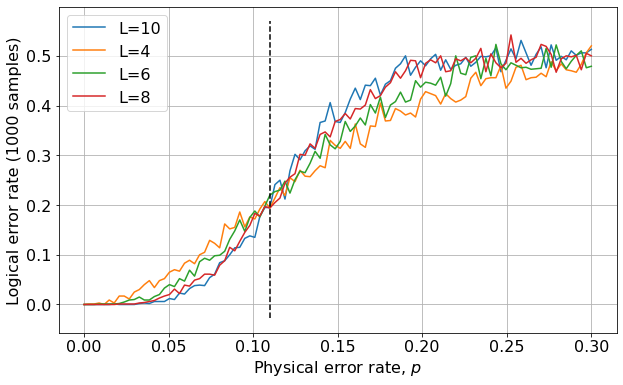

In [6]:
plt.rcParams.update({'font.size': 16})
BATCH = 4

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.grid(True)
ax.set_xlabel('Physical error rate, $p$')
ax.set_ylabel('Logical error rate (1000 samples)')
#ax.set_xscale('log')
#ax.set_yscale('log')

ps = np.linspace(0, 0.3, 102)
for fname in os.listdir(SAVE_DIR):
    if not fname.endswith('.csv'):
        continue
    fpath = os.path.join(SAVE_DIR, fname)
    L = int(fname.split('.')[0])
    error_array = np.loadtxt(fpath)
    mean_errors = error_array.mean(axis=-1)
    #ax.fill_between(xvals, yvals+error_stdev[-1], yvals-error_stdev[-1], alpha=0.3, zorder=1)
    ax.plot(ps, mean_errors, label=f'L={L}', zorder=2)

ax.vlines(0.11, *ax.get_ylim(), color='black', linestyle='dashed', zorder=3)
ax.legend()